<a href="https://colab.research.google.com/github/seungwoo-Jang/modu_quest/blob/main/EXPLORATION_RS4/E07/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

number of train examples : 1150
(256, 512, 3)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

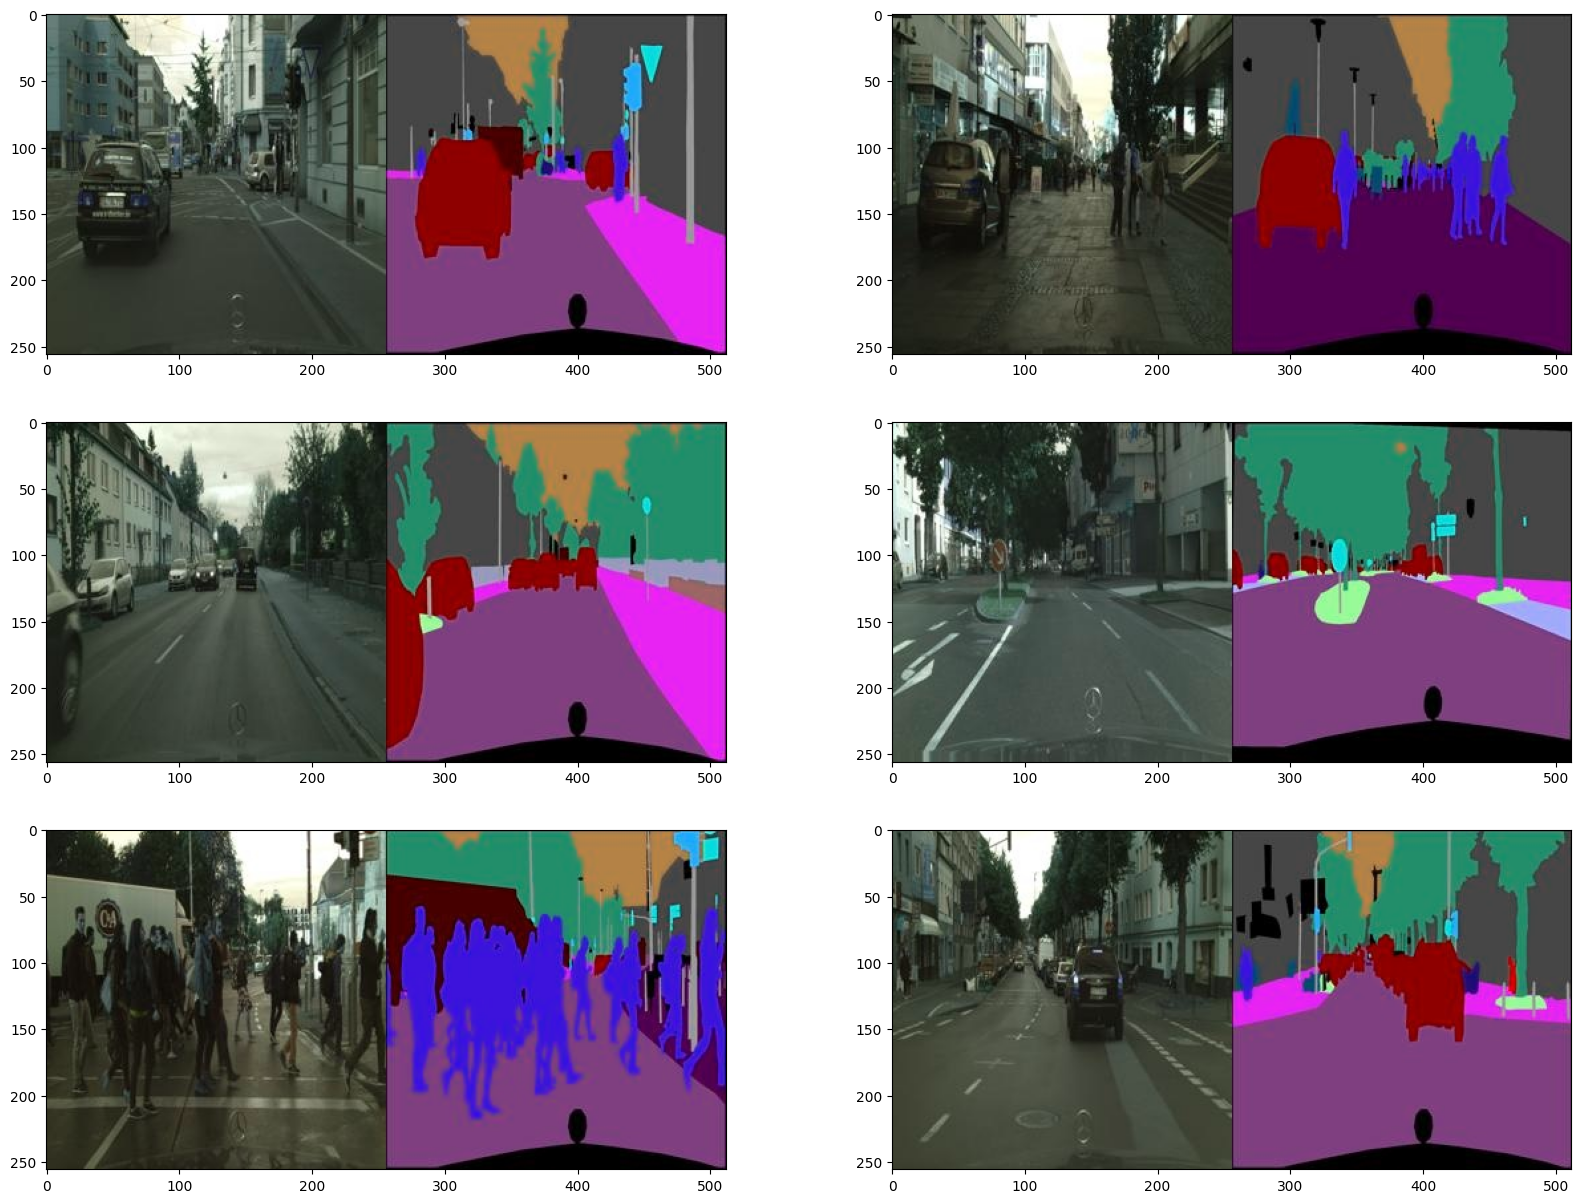

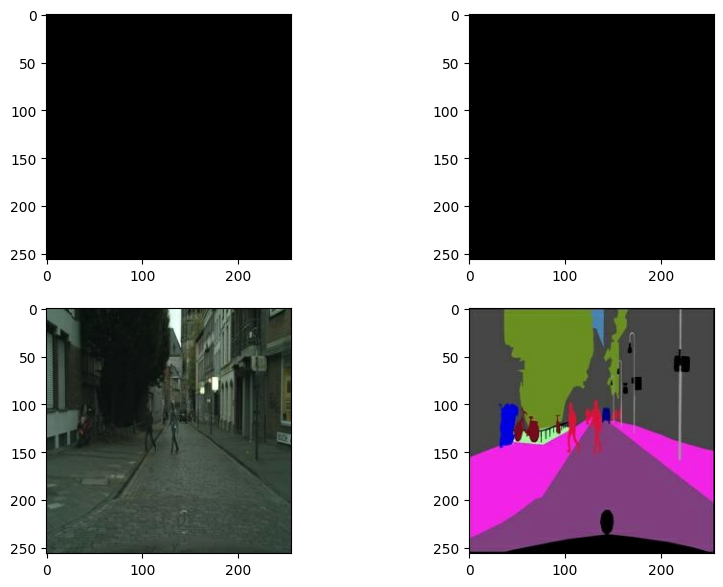

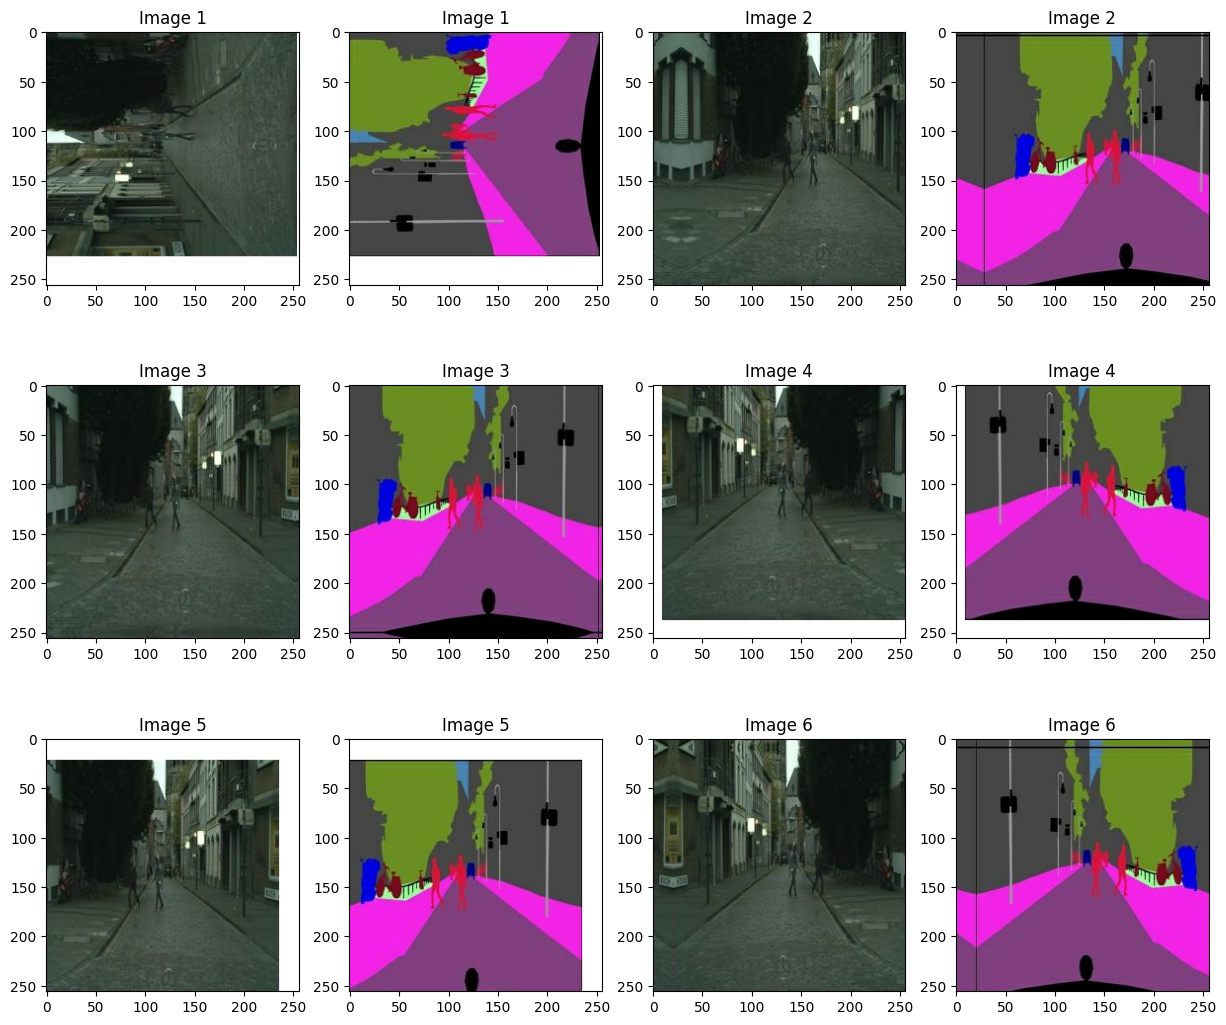

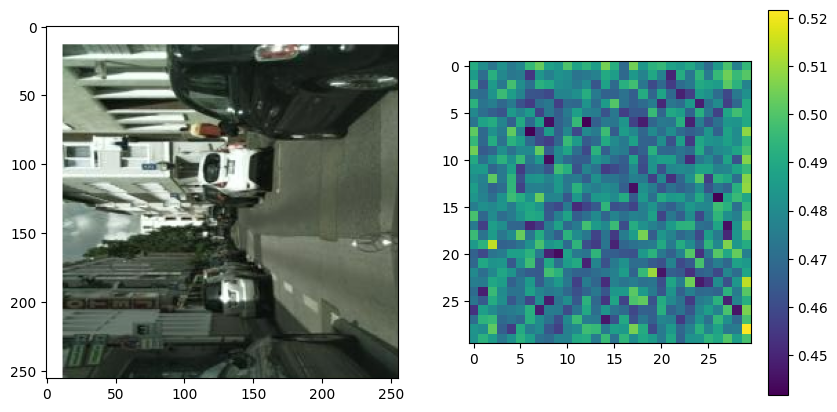

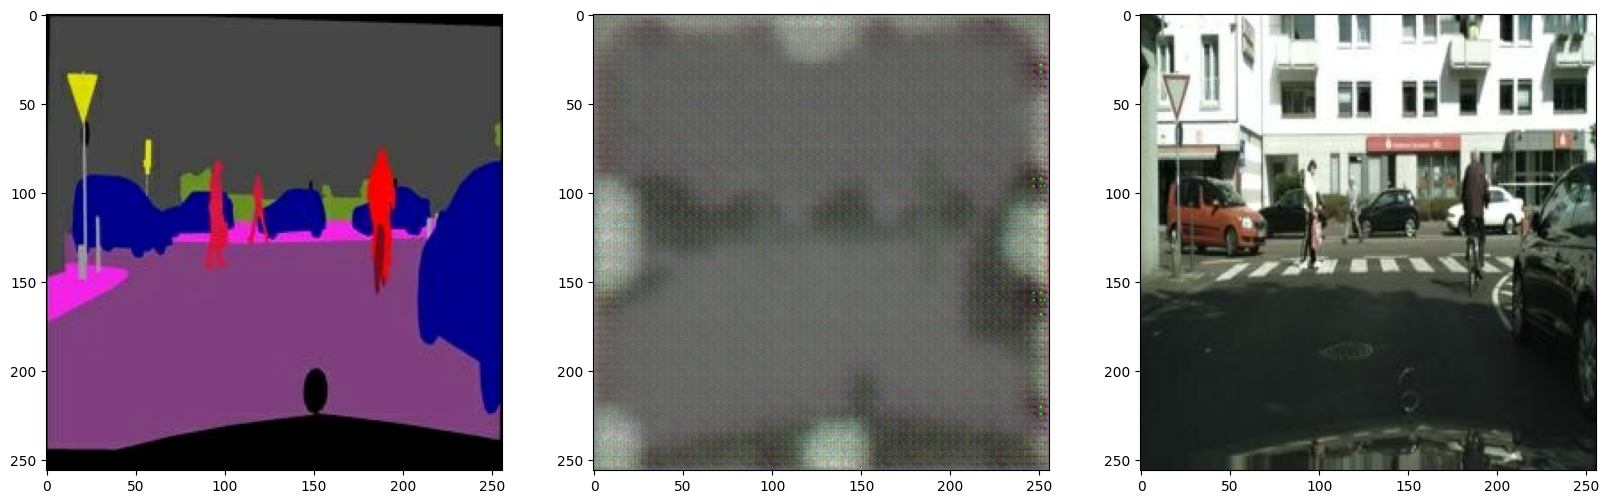

In [1]:
'''
1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.	
데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.
2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.	
U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.
3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.	
10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.
데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요.
(어떠한 방법을 사용했는지 적어주세요.)
이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.
모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.
1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 
좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.
'''

import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers


data_path = '/content/drive/MyDrive/Colab Notebooks/EXPLORATION_data/E07/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

plt.figure(figsize=(20,15)) #랜덤으로 6개 뽑아서 출력
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(830)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

f = data_path + os.listdir(data_path)[0] #이미지 형태 확인
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)    

def normalize(x): # 값들을 0~1로 변경
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x): # 값들을 원래대로 복구
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3) # 데이터를 디코딩하여 TensorFlow 텐서로 변환, 채널수
    
    w = tf.shape(img)[1] // 2 
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32) # TensorFlow의 데이터 타입 변환 함수 
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(2,2,3); plt.imshow(denormalize(sketch))
plt.subplot(2,2,4); plt.imshow(denormalize(colored))

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1) #-1 차원 기준으로 합치기
    
    _pad = tf.constant([[30,30],[30,30],[0,0]]) #패딩 추가
    if tf.random.uniform(()) < .5: # 조건문을 사용하여 50%의 확률로 패딩 방식을 선택합니다.
        padded = tf.pad(stacked, _pad, "REFLECT") # "REFLECT" 패딩 방식은 이미지 경계에서 대칭적으로 값을 반사시키는 방식
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.) # 주어진 상수 값으로 패딩을 추가

    out = image.random_crop(padded, size=[256, 256, 6]) # 이미지를 임의의 위치에서 크기 256x256으로 자르기
    
    out = image.random_flip_left_right(out) # 이미지를 좌우로 무작위로 뒤집기
    out = image.random_flip_up_down(out) # 이미지를 상하로 무작위로 뒤집기
    
    if tf.random.uniform(()) < .5: #  50%의 확률로 이미지를 임의로 회전
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   # out[...,:3]는 증강된 스케치 이미지, out[...,3:]는 증강된 컬러 이미지

plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4) # 섞는 버퍼에 최대 100개의 요소를 저장한 후, 배치 크기가 4인 배치로 분할

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator()) # 추출한 샘플을 NumPy 배열 형태로 변환
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5 # 역정규화

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))    

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

UNetGenerator().get_summary()

class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]
        # For문을 활용해서 DiscBlock을 쌓아주세요.
        # 조건 1 : 3번째까지 stride는 2로 주되 이후에는 1로 주세요
        # 조건 2 : 3번째까지 custom padding을 주지 않아도 되는데 이후에는 주세요.
        # 조건 3: 1번째와 5번째에서는 Batch Normalization을 사용하지 마세요.
        # 조건 4 : 1번째부터 4번째까지 LeakyReLU를 적용하고 마지막에는 sigmoid를 적용하세요. (sigmoid의 경우 따로 정의해야 합니다)
        self.sigmoid = layers.Activation('sigmoid')
        for i,f in enumerate(filters):
            if i < 3:
                if i == 0:
                  discblock = DiscBlock(f,use_bn=False)
                else:
                  discblock = DiscBlock(f)
            else:
                discblock = DiscBlock(f,stride=1,custom_pad=True)
                if i == 4:
                  discblock = DiscBlock(f,stride=1,custom_pad=True, act=False)
            self.blocks.append(discblock)

    def call(self, x, y):
        for i, block in enumerate(self.blocks):
            if i == 0:
                out = block([x,y])
            else:
              out = block(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
Discriminator().get_summary()

x = tf.random.normal([1,256,256,3]) # 정규 분포 텐서 생성, 종 모양의 대칭적인 분포 (평균과 표준 편차)
y = tf.random.uniform([1,256,256,3]) # 균등 분포 텐서 생성, 데이터가 일정한 확률로 모든 값 사이에서 균등하게 분포

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0]) # 배치크기, 차원 제거 
plt.colorbar() # 시각화된 이미지의 색상 척도

bce = losses.BinaryCrossentropy(from_logits=False) # 입력으로 들어오는 값에 시그모이드 함수를 적용한 후 손실을 계산
# from_logits=True로 설정되면 입력으로 들어오는 값에 시그모이드 함수를 적용하지 않습니다. 
# 즉, 입력으로 들어오는 값이 로짓(Logit) 값인 경우에 사용
mae = losses.MeanAbsoluteError() # 평균 절대 오차(Mean Absolute Error) 손실 함수

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
# 학습 속도, beta_1은 1차 모멘트 추정에 사용되는 지수 감소율, beta_2는 2차 모멘트 추정에 사용되는 지수 감소율

@tf.function # TensorFlow의 그래프 모드에서 실행
def train_step(real_sketch, colored): # color 넣고 예측 스케치 생성 
    noise = tf.random.normal([real_sketch.shape[0], real_sketch.shape[1], 
                              real_sketch.shape[2], real_sketch.shape[3]])
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        fake_sketch = generator(noise)

        real_disc = discriminator(real_sketch, colored)
        fake_disc = discriminator(fake_sketch, colored)

        gene_loss, l1_loss = get_gene_loss(fake_sketch, real_sketch, fake_disc)
        disc_loss = get_disc_loss(fake_disc, real_disc)

    gene_gradient = gene_tape.gradient(gene_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

test_path = '/content/drive/MyDrive/Colab Notebooks/EXPLORATION_data/E07/cityscapes/val/'
test_ind = 1

f = test_path + os.listdir(test_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(colored, 0)) # 텐서의 차원을 확장하여 크기가 1인 새로운 차원을 추가
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(colored))            
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(sketch))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')